In [631]:
%reload_ext autoreload
%autoreload 2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preproc as pp


class COVID(object):
    def __init__(self):
        self.DATA_PATH = "C:/Users/hp/Desktop/coviddata/"
        self.patient_route = pp.patient_route(self.DATA_PATH)
        self.case, self.group_map = pp.case(self.DATA_PATH)
        self.patient_info = pp.patient_info(self.DATA_PATH)
        self.patient_num = self.patient_info.shape[0]
        self.time = pp.time(self.DATA_PATH)
        self.pre_proc()

    def pre_proc(self):
        # >>> patient_info:
        # fill missing value: infection_case, use etc
        self.patient_info["infection_case"].fillna("etc", inplace=True)
        # fill missing value: contact_number, use 0
        self.patient_info["contact_number"].fillna(0, inplace=True)
        # fill missing value: infected_by, use -1
        self.patient_info["infected_by"].fillna(-1, inplace=True)
        # fill missing value: sex, use ratio of all, generate a shuffle list then fill in the blank
        sex_count = dict(self.patient_info["sex"].value_counts())
        sex_num = sex_count["female"] + sex_count["male"]
        un_sex_male = int((self.patient_num - sex_num) * sex_count["male"] / sex_num)
        un_sex_female = int((self.patient_num - sex_num) - un_sex_male)
        fill_sex_list = ["male" for _ in range(0, un_sex_male)] + ["female" for _ in range(0, un_sex_female)]
        random.shuffle(fill_sex_list)
        self.patient_info.loc[self.patient_info["sex"].isnull(), "sex"] = fill_sex_list
        # fill missing value: age, use mean of province
        # # 1. fill bo
        all_age = self.patient_info.birth_year.mean()
        province_age = self.patient_info.groupby('province').birth_year.mean()
        province_age.loc[province_age.isnull()] = all_age
        fill_birth_list_idx = self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"].index
        fill_birth_list = list(province_age[self.patient_info.loc[fill_birth_list_idx, "province"]])
        self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"] = fill_birth_list
        # # 2. fill age
        fill_age_list_idx = self.patient_info.loc[self.patient_info["age"].isnull(), "age"].index
        cal_year_list = np.array(list(self.patient_info.loc[fill_age_list_idx, "birth_year"]))
        cal_year_list = (2020 - cal_year_list) / 10
        cal_year_list = cal_year_list.astype(int) * 10
        cal_year_list = [str(cal_year_list[i]) + 's' for i in range(cal_year_list.shape[0])]
        self.patient_info.loc[self.patient_info["age"].isnull(), "age"] = cal_year_list
        # drop country
        self.patient_info.drop(columns=["country"], inplace=True)
        # fill missing value: city
        self.patient_info.loc[self.patient_info["city"] == "etc", "city"] = None
        self.patient_route["most_city"] = self.patient_route.groupby('patient_id').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        route_most_city = self.patient_route.groupby('patient_id').most_city.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            if pid in route_most_city.index:
                self.patient_info.loc[idx, "city"] = route_most_city[pid]
        self.patient_info["tmp"] = self.patient_info.groupby('province').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        prov_most_city = self.patient_info.groupby('province').tmp.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            # print(self.patient_info.loc[idx, "province"])
            self.patient_info.loc[idx, "city"] = prov_most_city[self.patient_info.loc[idx, "province"]]
        # fill last city and province
        ttp = self.patient_route.groupby("patient_id").last().reset_index()
        last_index = self.patient_info.loc[self.patient_info["patient_id"].isin(ttp["patient_id"])].index
        last_index = np.array(last_index)
        for idx in range(len(last_index)):
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_city"] = ttp.loc[idx, "city"]
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_province"] = ttp.loc[idx, "province"]
        null_last_idx = self.patient_info.loc[self.patient_info["last_city"].isnull()].index
        self.patient_info.loc[null_last_idx, "last_city"] = self.patient_info.loc[null_last_idx, "city"]
        self.patient_info.loc[null_last_idx, "last_province"] = self.patient_info.loc[null_last_idx, "province"]
        # fill disease
        self.patient_info["disease_b"] = 1
        self.patient_info.loc[self.patient_info["disease"].isnull(), "disease_b"] = 0
        self.patient_info["disease_b"].value_counts()
        # date formatting
        self.patient_info.loc[776, "symptom_onset_date"] = None
        self.patient_info["confirmed_date"] = pd.to_datetime(self.patient_info.confirmed_date)
        self.patient_info["symptom_onset_date"] = pd.to_datetime(self.patient_info.symptom_onset_date)
        self.patient_info["released_date"] = pd.to_datetime(self.patient_info.released_date)
        self.patient_info["deceased_date"] = pd.to_datetime(self.patient_info.deceased_date)
        self.time["date"] = pd.to_datetime(self.time.date)

        # >>> patient_route:
        self.patient_route["date"] = pd.to_datetime(self.patient_route.date)
        self.patient_info["start_date"] = pd.NaT
        for i, row in self.patient_info.iterrows():
            pid = row["patient_id"]
            dating = self.patient_route[self.patient_route["patient_id"] == pid]
            self.patient_info.loc[self.patient_info["patient_id"] == pid, "group"] = self.group_map[row["infection_case"]]
            if row["symptom_onset_date"] is not pd.NaT:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                dating_b = dating[dating["date"] <= row["symptom_onset_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
            else:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                dating_b = dating[dating["date"] <= row["confirmed_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
        print(self.patient_info.isnull().sum())
        # fill missing value: sym date
        # self.patient_info.to_excel("./tmp/patient_info.xlsx")


In [632]:
covid=COVID()

patient_id               0
sex                      0
birth_year               0
age                      0
province                 0
city                     0
infection_case           0
infected_by              0
contact_number           0
disease               3110
symptom_onset_date    2683
confirmed_date           0
released_date         2147
deceased_date         3072
state                    0
group                    0
tmp                      0
last_city                0
last_province            0
disease_b                0
start_date               0
dtype: int64


In [633]:
info=covid.patient_info
time=covid.time

我们将年龄段age转化为数值型变量，例如'50s'变为50，以便进行接下来的分析。

In [634]:
for i in range(len(info["age"])):
    info["age"][i]=int(info["age"][i].strip("s"))

E:\anacode\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [323]:
##### 查漏补缺
info["city"][37]="Songpa-gu"
info["city"][106]="Geumcheon-gu"
info["city"][269]="Gangnam-gu"
info["city"][385]="Guro-gu"
info["province"][562]="Chungcheongnam-do"
info["city"][771]="Seo-gu"
info["city"][1812]="Mokpo-si"
info["last_province"][562]="Chungcheongnam-do"

E:\anacode\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\anacode\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
E:\anacode\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\anacode\lib\site-pac

此处将"sex"变量转化为0，1型变量，其中male为1，将group（群体感染）转变为0，1型变量，1代表群体感染。

In [635]:
new_sex=pd.get_dummies(info["sex"])
info["sex"]=new_sex["male"]#### male 为1
a = np.array(info["group"])
group=a.astype(int)
info["group"]=group#### group 为1

####disease_b 0  无病

In [636]:
timeage=pd.read_csv("C:/Users/hp/Desktop/coviddata/TimeAge.csv")
timegender=pd.read_csv("C:/Users/hp/Desktop/coviddata/TimeGender.csv")
timeprovince=pd.read_csv("C:/Users/hp/Desktop/coviddata/TimeProvince.csv")
region=pd.read_csv("C:/Users/hp/Desktop/coviddata/Region.csv")

In [653]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns

#### plot of deceased
deceased=info[info["state"]=="deceased"]

从图中我们可以看到，死亡者中感染状况为非群体感染的人数较远多于其他情况。

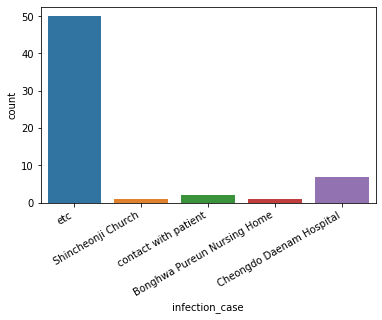

In [655]:
deceased_case=sns.countplot(x="infection_case", data=deceased)
plt.gcf().autofmt_xdate() 

男性的死亡人数多于女性。

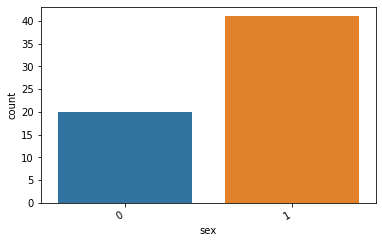

In [656]:
deceased_sex=sns.countplot(x="sex", data=deceased)
plt.gcf().autofmt_xdate() 

死亡的病人中，最多的是来自Gyeongsangbuk-do和Daegu这两个地方

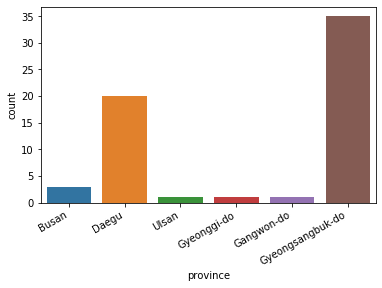

In [657]:
deceased_province=sns.countplot(x="province", data=deceased)
plt.gcf().autofmt_xdate()

我们可以看出，死亡的病人多为60，70，80代，因此我们可以粗略看出，此病毒对于免疫力低下的老龄人口具有较大的威胁性。

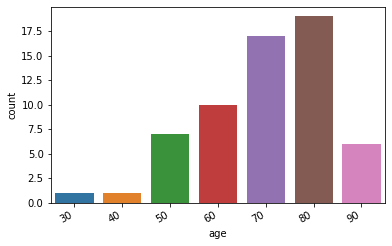

In [658]:
deceased_age=sns.countplot(x="age", data=deceased)
plt.gcf().autofmt_xdate() 

根据累计死亡人数和累计确诊人数的时间序列图，我们可以看出韩国感染人数从2月下旬开始呈现爆发性的增长，到3月中旬增长速度较为缓和，而死亡人数增速一直呈现上升趋势。

Text(0.5, 1, 'Deceased Number')

<Figure size 432x288 with 0 Axes>

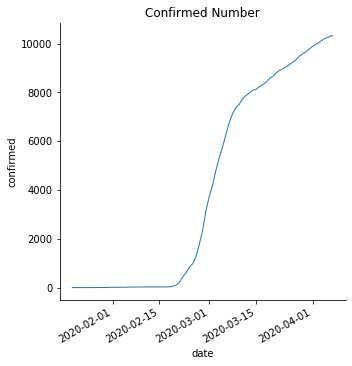

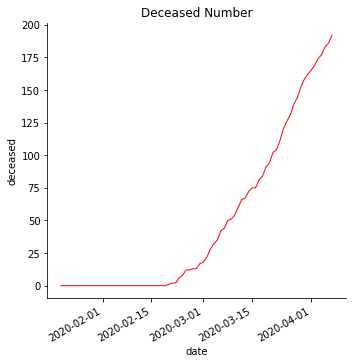

In [638]:
### plot of confirmed
plt.figure()
conf= sns.relplot(x="date", y="confirmed", kind="line", linewidth=1.0, label="confirmed",data=time) 
plt.gcf().autofmt_xdate() 
plt.title("Confirmed Number")
deceased= sns.relplot(x="date", y="deceased", kind="line",color='red', linewidth=1.0, label='deceased',data=time)
plt.gcf().autofmt_xdate()  
plt.title("Deceased Number")

接下来，我们根据patientInfo中的病人籍贯地点对该地点教育水平进行合并，根据PatientRoute的中病人接受治疗的地点对该地点医疗负荷数据进行了合并。我们提取出了状态为released的病人数据，将出院时间和确诊时间进行相减粗略得到病人康复所需时间，并结合并性别、年龄、群体感染与否、学术水平以及医疗负荷水平进行了相关系数的计算。我们发现病人康复所需时间与其他变量之间的相关性非常弱，因此我们认为这些变量对于病人康复所需时间不具有明显的解释性。

In [659]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
region["last_province"]=region["province"]
region["last_city"]=region["city"]
part1=region[["province","city","elementary_school_count","kindergarten_count","university_count","academy_ratio"]]
part2=region[["last_province","last_city","elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]]
info1=pd.merge(info,part1,on = ["province","city"],how = "left")
final_info=pd.merge(info1,part2,on = ['last_province','last_city'],how = 'left')

In [ ]:
released=final_info[final_info["released_date"].isnull()!=True]
released=released[released["state"]=="released"]
rctime=released["released_date"]-released["confirmed_date"]
rctime=rctime.dt.days[0:len(rctime)]
released["recoverytime"]=rctime
names=["sex","age","group","elementary_school_count","kindergarten_count","university_count","academy_ratio",\
       "elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]
x=released[names]
y=released["recoverytime"]
ddd=pd.concat([x,y],axis=1)
ddd.corr() ### 可见recoverytime与其他变量之间的

我们接下来对病人是否死亡或者出院进行了分类预测。主要利用性别、年龄、群体感染与否、学术水平以及医疗负荷水平等变量。首先，我们将数据随机分为测试集和训练集，测试集所占比例为0.3。在测试集和训练集中，死亡人数所占比例相差不大，约为0.05。

In [382]:
dataclf=final_info[final_info["state"]!="isolated"]
iso=final_info[final_info["state"]=="isolated"]

In [411]:
names=["sex","age","group","disease_b","elementary_school_count","kindergarten_count","university_count","academy_ratio",
              "elderly_population_ratio","elderly_alone_ratio" ,"nursing_home_count"]
y = dataclf["state"]
x = dataclf[names]
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [405]:
print(y_test.value_counts()/len(y_test))

released    0.952646
deceased    0.047354
Name: state, dtype: float64


In [435]:
print(y_train.value_counts()/len(y_trian))

released    0.947305
deceased    0.052695
Name: state, dtype: float64


我们首先考虑朴素贝叶斯模型。

In [661]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
classifier = MultinomialNB().fit(x_train,y_train)
test_pred = classifier.predict(x_test)
train_pred = classifier.predict(x_train)

#### 模型性能评估

In [437]:
metrics.confusion_matrix(y_test, test_pred)

array([[ 17,   0],
       [ 96, 246]], dtype=int64)

In [438]:
print(metrics.classification_report(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.15      1.00      0.26        17
    released       1.00      0.72      0.84       342

    accuracy                           0.73       359
   macro avg       0.58      0.86      0.55       359
weighted avg       0.96      0.73      0.81       359




接下来我们考虑运用随机森林分类。

### 随机森林

In [441]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as con

In [662]:
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
###返回由训练集训练成的模型对验证集预测的结果
test_pred = rf.fit(x_train,y_train).predict(x_test)
###打印混淆矩阵
print('\n'+'混淆矩阵：')
print(con(y_test,test_pred))
###打印测试准确率
print('\n'+'Accuracy:')
print(rf.score(x_test,y_test))


混淆矩阵：
[[ 14   3]
 [  7 335]]

Accuracy:
0.9721448467966574


E:\anacode\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [449]:
print(metrics.classification_report(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.67      0.82      0.74        17
    released       0.99      0.98      0.99       342

    accuracy                           0.97       359
   macro avg       0.83      0.90      0.86       359
weighted avg       0.98      0.97      0.97       359



对比朴素贝叶斯，我们可以看到运用了随机森林的算法分类的效果更好。更多的实际出院病人被进行了正确的预测分类。

In [450]:
feature_imp = pd.Series(rf.feature_importances_)
feature_imp.index = x.columns
sorteds_features = feature_imp.sort_values(ascending=False)
sorteds_features
# The following is DataFrame format of the feature importance vector
feature_impDF = pd.DataFrame()
feature_impDF["importance"] = rf.feature_importances_
feature_impDF["feature"] = x.columns
feature_impDF.sort_values("importance",ascending=False,inplace=True)
feature_impDF

,importance,feature
1,0.506830,age
4,0.111005,elementary_school_count
9,0.073635,elderly_alone_ratio
7,0.064065,academy_ratio
8,0.056523,elderly_population_ratio
5,0.055110,kindergarten_count
10,0.037076,nursing_home_count
0,0.035115,sex
6,0.032094,university_count
2,0.016091,group


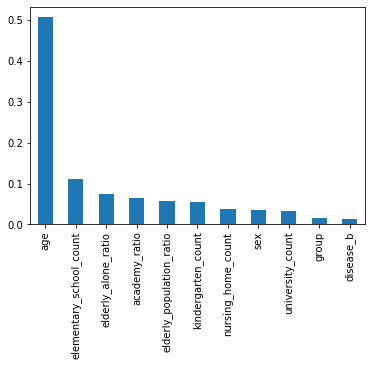

In [451]:
sorteds_features.plot(kind="bar")

从上面的计算和作图中，我们可以看到年龄是最重要的特征，相比年轻人，高龄病人更容易死亡，我们可以看到文化水平和医疗水平等相关的变量的重要性远
小于年龄，而性别，是否为群体感染，是否患病对于病人是否死亡并没有特别大的作用。我们接下来对随机森林进行参数的调优。

### 随机森林进行调优

In [454]:
from sklearn.model_selection import GridSearchCV
import numpy as np
rf2 = RandomForestClassifier()
parameters = {"n_estimators":np.arange(10,100,10),"criterion":["gini","entropy"]}
grid_rf2 = GridSearchCV(estimator=rf2, param_grid=parameters, cv=5,scoring="accuracy")
grid_rf2.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [459]:
print(grid_rf2.best_params_) 

{'criterion': 'gini', 'n_estimators': 20}


根据网格计算，我们得到，最优的迭代为20次，此时的标准是gini指数。下面是运用这两个优化的参数进行新模型的建立。

In [460]:
rf3 = RandomForestClassifier(class_weight='balanced',random_state=1,criterion="gini", n_estimators=20)
###返回由训练集训练成的模型对验证集预测的结果
test_pred = rf3.fit(x_train,y_train).predict(x_test)
###打印混淆矩阵
print('\n'+'混淆矩阵：')
print(con(y_test,test_pred))
###打印测试准确率
print('\n'+'Accuracy:')
print(rf3.score(x_test,y_test))


混淆矩阵：
[[ 13   4]
 [  4 338]]

Accuracy:
0.9777158774373259


In [461]:
print(metrics.classification_report(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.76      0.76      0.76        17
    released       0.99      0.99      0.99       342

    accuracy                           0.98       359
   macro avg       0.88      0.88      0.88       359
weighted avg       0.98      0.98      0.98       359



优化后的新随机森林模型对于死亡病人的预测召回率有所下降，而对于康复病人的预测召回率有所提升，总体来讲，rg3模型对于病人的状态分类效果有所提升。
以下我们考虑 KNN 模型。

### KNN

In [463]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 11)
knn_model.fit(x_train,y_train)
test_pred = knn_model.predict(x_test)
from sklearn import metrics
print(metrics.classification_report(y_test,test_pred))
print(metrics.confusion_matrix(y_test,test_pred))
print(metrics.accuracy_score(y_test,test_pred))

              precision    recall  f1-score   support

    deceased       0.62      0.47      0.53        17
    released       0.97      0.99      0.98       342

    accuracy                           0.96       359
   macro avg       0.79      0.73      0.76       359
weighted avg       0.96      0.96      0.96       359

[[  8   9]
 [  5 337]]
0.9610027855153204


我们可以看到，过半死亡状态的病人被预测为出院状态，因此对于死亡状态的预测不够准确，需要优化KNN模型。我们设置了k=1至21之间的奇数，对这些k的值都进行了模型拟合。

In [479]:
k_list=[1,3,5,7,9,11,13,15,17,19,21]
for k in k_list:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(x_train,y_train)
    test_pred = knn_model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,test_pred)
    confusion_mat = metrics.confusion_matrix(y_test,test_pred)
    
    print("k = ",k)
    print("\t正确率: ", '%.2f'%(accuracy*100) + "%")
    print("\t假阴性：",confusion_mat[0,1]/(confusion_mat[0,1]+confusion_mat[0,0]))
    print("","\t假阳性：",confusion_mat[1,0]/(confusion_mat[1,0]+confusion_mat[1,1]))

k =  1
	正确率:  97.21%
	假阴性： 0.35294117647058826
 	假阳性： 0.011695906432748537
k =  3
	正确率:  97.77%
	假阴性： 0.35294117647058826
 	假阳性： 0.005847953216374269
k =  5
	正确率:  96.66%
	假阴性： 0.5882352941176471
 	假阳性： 0.005847953216374269
k =  7
	正确率:  96.66%
	假阴性： 0.5882352941176471
 	假阳性： 0.005847953216374269
k =  9
	正确率:  96.94%
	假阴性： 0.4117647058823529
 	假阳性： 0.011695906432748537
k =  11
	正确率:  96.10%
	假阴性： 0.5294117647058824
 	假阳性： 0.014619883040935672
k =  13
	正确率:  95.82%
	假阴性： 0.7647058823529411
 	假阳性： 0.005847953216374269
k =  15
	正确率:  95.82%
	假阴性： 0.7647058823529411
 	假阳性： 0.005847953216374269
k =  17
	正确率:  96.10%
	假阴性： 0.7647058823529411
 	假阳性： 0.0029239766081871343
k =  19
	正确率:  96.38%
	假阴性： 0.7058823529411765
 	假阳性： 0.0029239766081871343
k =  21
	正确率:  96.38%
	假阴性： 0.7058823529411765
 	假阳性： 0.0029239766081871343


可以看出预测出的假阴性所占的比例随k值增大逐渐上升，准确率逐渐下降，当k等于1的时候，假阴性为0.35，对于我们之前优化过的随机森林模型（假阴性为0.24），knn模型在这里并不是最优的模型。
综上我们选择调优过后的随机森林模型rg3作为一个较好的分类出院和病死的分类模型。

# SIR模型预测

In [644]:
time=covid.time
weatherdata=pd.read_csv("C:/Users/hp/Desktop/coviddata/Weather.csv")
search=pd.read_csv("C:/Users/hp/Desktop/SearchTrend.csv")
trend=search[1480:1558]["coronavirus"]/100
N=51269185
I=time["confirmed"]-(time["released"]+time["deceased"])
I=I.values
I=I[0:len(I)-1]
weather=weatherdata[23679:24927]["avg_temp"].values
templist=[]
for i in range(78):
  sublist=[]
  for j in range((i-1)*16+1,(i*16)+1):
    sublist.append(weather[j])
  mid=np.median(sublist)
  templist.append(mid)###77
tem=templist   
del tem[-1]  
R=time["released"]
R=R.values
R=R[0:len(R)-1]
D=time["deceased"]
D=D.values
D=D[0:len(D)-1]
RR=R+D
triS=N-I-RR
def delta(a):
    delta = []	#生成一个空列表，用来放新列表
    for i in range(len(a)-1):
        b =a[i+1] - a[i]
        delta.append(b)	
    return delta

deltaSS=delta(triS)
deltaR=delta(R)
deltaD=delta(D)
deltaI=delta(I)
II=I[0:len(I)-1]
SS=triS[0:len(triS)-1]
tren=trend[0:len(trend)-1]
col1=-II*SS/N
col11=col1.tolist()
col11.extend([i * (-1) for i in col11])
for i in [0]*154:
    col11.append(i)
col1=col11    

col2=-np.array(tem)*II*SS/N
col22=col2.tolist()
col22.extend([i * (-1) for i in col22])
for i in [0]*154:
    col22.append(i)
col2=col22  

col3=-tren*II*SS/N
col33=col3.tolist()
col33.extend([i * (-1) for i in col33])
for i in [0]*154:
    col33.append(i)
col3=col33

col4=[0]*77
col4.extend([i for i in (-II).tolist()])
col4.extend([i for i in II.tolist()])
col4.extend([0]*77)

col5=[0]*77
col5.extend([i for i in (-II).tolist()])
col5.extend([0]*77)
col5.extend([i for i in II.tolist()])

Y=deltaSS
Y.extend(deltaI)
Y.extend(deltaR)
Y.extend(deltaD)

Y=np.array(Y)
X=np.array([col1,col2,col3,col4,col5])
n=len(col1)
X=X.reshape(n,-1)
Y=Y.reshape(n,-1)
linreg = LinearRegression()
linreg.fit(X, Y)

print(linreg.coef_)



[[-1.03590228e-03  1.78965383e-03 -6.58686323e-05 -5.02646780e-04
   6.34980462e-04]]


In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x.astype(float),y)
print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(x) - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

In [371]:
regr = linear_model.LinearRegression()
regr.fit(x.astype(float),y)
print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(x) - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

Intercept: 18.52
Coefficients: 
[ 0.20697447  0.03114256  0.79947687 -0.04040309  0.03776218  0.21718636
  0.49904658 -0.66103802  1.2454516  -0.00195259]
Residual sum of squares: 53.73
Variance score: 0.05


In [348]:
type(y)

pandas.core.series.Series

In [373]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table 
ols = sm.OLS(y,x.astype(float)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           recoverytime   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              691.5
Date:                Wed, 03 Jun 2020   Prob (F-statistic):                        0.00
Time:                        13:34:14   Log-Likelihood:                         -3370.3
No. Observations:                 979   AIC:                                      6761.
Df Residuals:                     969   BIC:                                      6809.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sex                          0.8116      0.508      1.599      0.110      -0.185       1.808
age                          0.0605      0.013      4.510      0.000       0.034       0.087
group                        1.1540      0.786      1.467      0.143      -0.389       2.697
elementary_school_count     -0.0223      0.040     -0.559      0.577      -0.101       0.056
kindergarten_count           0.0677      0.024      2.840      0.005       0.021       0.114
university_count             0.3502      0.082      4.269      0.000       0.189       0.511
academy_ratio                3.6997      0.531      6.965      0.000       2.657       4.742
elderly_population_ratio     0.3544      0.178      1.995      0.046       0.006       0.703
elderly_alone_ratio          0.2723      0.304      0.897      0.370      -0.323       0.868
nursing_home_count          -0.0029      0.001     -3.624      0.000      -0.004      -0.001
==============================================================================
Omnibus:                       17.580   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.835
Skew:                           0.203   Prob(JB):                     0.000990
Kurtosis:                       2.583   Cond. No.                     2.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
from sklearn import preprocessing
names=["elementary_school_count","kindergarten_count","university_count","academy_ratio",\
       "elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]
edumedi=final_info[names]
edumedi_zscored = pd.DataFrame(preprocessing.scale(edumedi),columns = edumedi.columns)
final_info[names]=edumedi_zscored

In [282]:
released=final_info[final_info["released_date"].isnull()!=True]
rctime=released["released_date"]-released["confirmed_date"]
rctime=rctime.dt.days[0:len(rctime)]
released["recoverytime"]=rctime

E:\anacode\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [331]:
released

,patient_id,sex,birth_year,age,province,city,infection_case,infected_by,contact_number,disease,...,disease_b,start_date,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count,infectedtime
0,1000000001,1,1964.0,50,Seoul,Gangseo-gu,overseas inflow,-1.000000e+00,75.0,NaN,...,0,2020-01-22,36,56,1,1.17,18.42,7.4,728,1
1,1000000002,1,1987.0,30,Seoul,Jungnang-gu,overseas inflow,-1.000000e+00,31.0,NaN,...,0,2020-01-30,23,31,1,0.70,16.65,6.9,689,0
2,1000000003,1,1964.0,50,Seoul,Jongno-gu,contact with patient,2.002000e+09,17.0,NaN,...,0,2020-01-26,13,17,3,1.71,18.27,6.8,668,4
3,1000000004,1,1991.0,20,Seoul,Mapo-gu,overseas inflow,-1.000000e+00,9.0,NaN,...,0,2020-01-26,22,24,2,1.83,16.65,6.9,689,4
4,1000000005,0,1992.0,20,Seoul,Seongbuk-gu,contact with patient,1.000000e+09,2.0,NaN,...,0,2020-01-31,29,49,6,1.02,16.65,6.9,689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,6100000084,1,1971.0,40,Gyeongsangnam-do,Geoje-si,etc,-1.000000e+00,0.0,NaN,...,0,2020-03-11,38,58,1,1.76,10.22,4.7,317,0
3119,7000000001,1,1998.0,20,Jeju-do,Jeju-do,etc,-1.000000e+00,87.0,NaN,...,0,2020-02-20,113,123,4,1.53,15.10,6.4,1245,0
3120,7000000002,0,1998.0,20,Jeju-do,Jeju-do,etc,-1.000000e+00,84.0,NaN,...,0,2020-02-22,113,123,4,1.53,15.10,6.4,1245,0
3121,7000000003,0,1972.0,40,Jeju-do,Jeju-do,etc,-1.000000e+00,21.0,NaN,...,0,2020-03-02,113,123,4,1.53,15.10,6.4,1245,0


In [253]:
y=released["recoverytime"]
x=released.drop(["recoverytime"], axis = 1)

In [254]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train=y_train.reset_index(drop = True)
y_test=y_test.reset_index(drop = True)
x_train=x_train.reset_index(drop = True)
x_test=x_test.reset_index(drop = True)

In [288]:
x_new=released[["sex","age","group","elementary_school_count","kindergarten_count","university_count","academy_ratio",
              "elderly_population_ratio","elderly_alone_ratio" ,"nursing_home_count"]]
y=released["recoverytime"]

### 先对教育和医疗PCA再进行回归 各保留2个主成分

In [255]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.decomposition import PCA as RandomizedPCA
name1=["elementary_school_count","kindergarten_count","university_count","academy_ratio"]
name2=["elderly_population_ratio","elderly_alone_ratio","nursing_home_count"]
n1= 2
n2= 2
pca1 = RandomizedPCA(n_components=n1).fit(x_train[name1])
print(round(sum(pca1.explained_variance_ratio_),2))
pca2 = RandomizedPCA(n_components=n2).fit(x_train[name2])
print(round(sum(pca2.explained_variance_ratio_),2))

0.87
0.99


In [256]:
x_train_pca1 = pd.DataFrame(pca1.transform(x_train[name1]))
x_train_pca2 = pd.DataFrame(pca2.transform(x_train[name2]))
x_test_pca1 = pd.DataFrame(pca1.transform(x_test[name1]))
x_test_pca2 = pd.DataFrame(pca2.transform(x_test[name2]))
x_train_pca1.columns=["edu_cp1","edu_cp2"]
x_train_pca2.columns=["medi_cp1","medi_cp2"]
x_test_pca1.columns=["edu_cp1","edu_cp2"]
x_test_pca2.columns=["medi_cp1","medi_cp2"]

In [257]:
x_train_=pd.concat([x_train,x_train_pca1,x_train_pca2],axis=1)
var=["sex","birth_year","group","edu_cp1","edu_cp2","medi_cp1","medi_cp2"]
x_train_new=x_train_[var]
x_test_=pd.concat([x_test,x_test_pca1,x_test_pca2],axis=1)
x_test_new=x_test_[var]

In [258]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train_new,y_train)

print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(x_train_new) - y_train) ** 2))
print('Variance score: %.2f' % regr.score(x_train_new, y_train))

Intercept: 91.35
Coefficients: 
[ 0.36731953 -0.03611529  0.65257135  0.90503171 -0.49767427  1.3904571
 -0.95354339]
Residual sum of squares: 55.02
Variance score: 0.04


In [270]:
age=2020-x_train_new["birth_year"]
age2=age**3

In [271]:
ddd=pd.concat([x_train_new[["sex","group","edu_cp1","edu_cp2","medi_cp1","medi_cp2"]],y_train,age2],axis=1)
ddd.corr()

,sex,group,edu_cp1,edu_cp2,medi_cp1,medi_cp2,recoverytime,birth_year
sex,1.000000,-0.053020,-1.824427e-02,2.016241e-01,-1.389911e-02,8.706286e-02,-0.014739,-0.099318
group,-0.053020,1.000000,1.939067e-02,2.233390e-01,1.101484e-02,-5.080293e-03,0.025169,0.128447
edu_cp1,-0.018244,0.019391,1.000000e+00,6.305777e-16,-6.610104e-01,2.548335e-01,-0.014078,-0.168320
edu_cp2,0.201624,0.223339,6.305777e-16,1.000000e+00,-4.067706e-02,3.148033e-01,-0.090773,-0.055039
medi_cp1,-0.013899,0.011015,-6.610104e-01,-4.067706e-02,1.000000e+00,-1.683913e-17,0.111773,0.117677
medi_cp2,0.087063,-0.005080,2.548335e-01,3.148033e-01,-1.683913e-17,1.000000e+00,-0.064801,-0.051687
recoverytime,-0.014739,0.025169,-1.407795e-02,-9.077346e-02,1.117730e-01,-6.480123e-02,1.000000,0.072318
birth_year,-0.099318,0.128447,-1.683202e-01,-5.503886e-02,1.176773e-01,-5.168699e-02,0.072318,1.000000
